## Setup and Load Data

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib pydot

In [2]:
import tensorflow as tf 
import os 
from matplotlib import pyplot as plt 
import numpy as np 
import pandas as pd 
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle


In [3]:
# # avoid OOM error by limiting GPU memory consumption 
# gpus = tf. config.experimental.list_physical_devices('GPU')

# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True) 

### Load Data

dataset from kaggle: https://www.kaggle.com/datasets/hasyimabdillah/workoutexercises-images/data

In [4]:
data = tf.keras.utils.image_dataset_from_directory('data', batch_size=16)

Found 13853 files belonging to 22 classes.


In [5]:
class_names= data.class_names
num_classes = len( class_names)

In [6]:
data_iterator = data.as_numpy_iterator() 
data_iterator

In [7]:
# images represented as numpy arrays in batches of 32 images (check documentation )
batch = data_iterator.next() 

In [8]:
#labels 
batch[1]

array([12, 19, 20, 21, 18, 18, 14,  9,  1,  5, 20,  5,  2, 18,  2, 21])

In [9]:
#number of batches 
len(data)

866

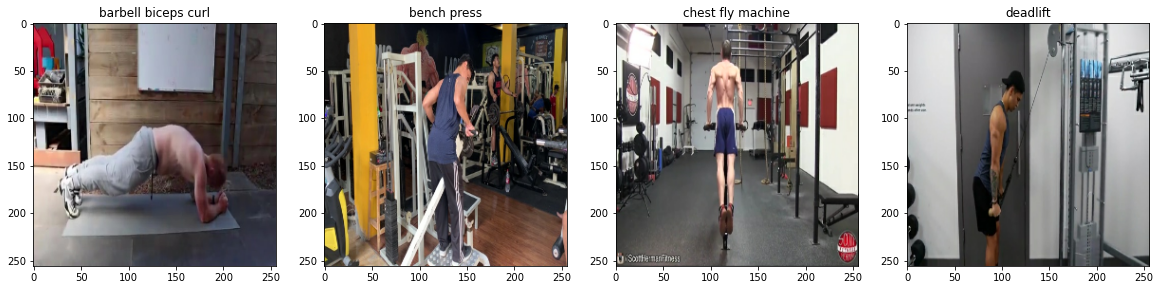

In [10]:
#check the some images of the batch with their respective class

fig, ax = plt.subplots(ncols=4, figsize = (20, 20))

for idx, img in enumerate (batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(class_names[idx])

## Preprocess data

#### scale data

In [11]:
scale_data = data.map(lambda x,y: (x/255, y))

scaled_iterator = scale_data.as_numpy_iterator()

batch = scaled_iterator.next()

#### split data

In [12]:
len(scale_data)

866

In [13]:
# 70 % for training , 20% for validation and 10% for testing 

train_size = int(len(scale_data)* .7)

val_size = int(len(scale_data)* .2)

test_size = int(len(scale_data)* .1) + 1

In [14]:
train = scale_data.take(train_size)

val = scale_data.skip(train_size).take(val_size)

test = scale_data.skip(train_size + val_size).take(test_size)

## Deep Learning 


#### Build Deep Learnig Model

In [15]:
#model dependencies 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout 

In [16]:
model = Sequential()

####  Basic/first Arquitecture

Para el primer modelo de CNN que probamos nos basamos en lo que hay en el estado del arte para hacer la prueba control, para esto generamos un modelo secuencial teniendo: 


  - <b> input Layer: </b> la primera capa convolucional que recibe imágenes con una forma de 256x256 píxeles con 3 canales de color (RGB). Utiliza 16 filtros de tamaño 3x3 con un paso (stride) de 1 y la función de activación ReLU, después de la primera capa convolucional tenemos la primera capa de MaxPooling, esta capa reduce la dimensión espacial (ancho y alto) de la entrada a la mitad.


  - <b> bloques convolutivos: </b> Una segunda capa convolucional con 32 filtros. La entrada a esta capa es la salida de la capa de agrupamiento anterior, seguida de otra capa de MaxPooling, luego una tercera capa convolucional con 16 filtros que tambien sigue el parton de las capas anteriores seguida a su vez por otra capa de MaxPooling.


  - <b> Aplanamiento: </b> Esta capa convierte el mapa de características 3D resultante de las capas convolutivas y de MaxPooling en un vector de una sola dimension. 

  - <b> Capas Densa: </b> Una capa densa con 256 neuronas y función de activación ReLU.


  - <b> Output Layer: </b>  La última capa densa tiene un número de neuronas igual al número de clases que se quieren predecir (22 en nuestro caso). Utiliza la función de activación softmax, la cual es común para problemas de clasificación multiclase, ya que los valores de salida representarán las probabilidades de cada clase.

In [17]:
#convolution blocks 
#input layer
model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
model.add(Dense(num_classes, activation = 'softmax'))

In [18]:
model.compile('adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [19]:
# Summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

###

### vizualizacion de la arquitectura del modelo

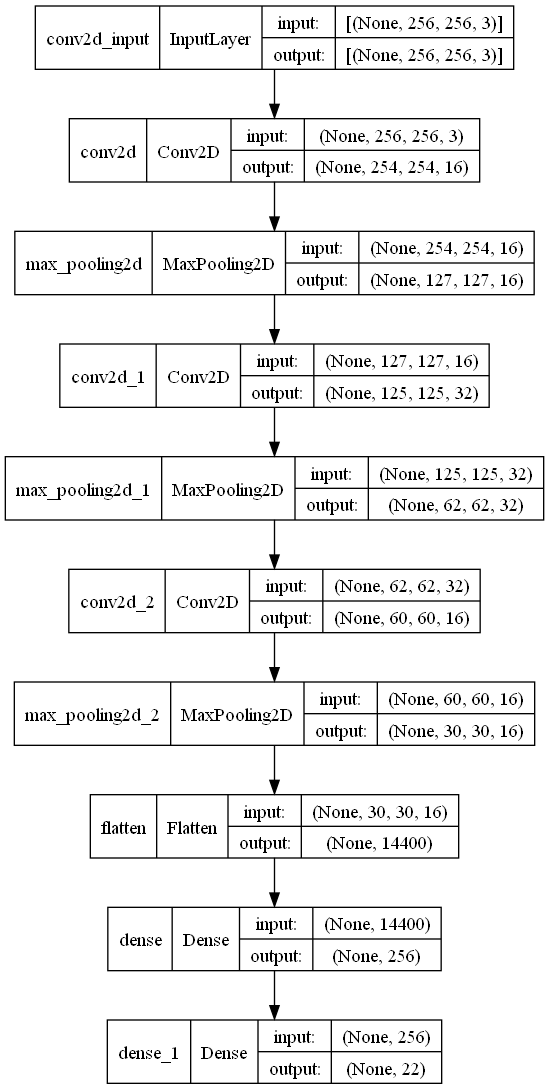

In [20]:
from tensorflow.keras.utils import plot_model


from tensorflow.keras.utils import plot_model


directory = 'model architecture'
if not os.path.exists(directory):
    os.makedirs(directory)

plot_model(model, to_file=f'{directory}/controlModel.png', show_shapes=True)


## Training the model

In [21]:
logDir = 'logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logDir)

In [22]:
hist = model.fit(train, epochs = 20, validation_data = val, callbacks = [tensorboard_callback])

Epoch 1/20
606/606 [==============================] - 23s 31ms/step - loss: 1.0205 - accuracy: 0.7419 - val_loss: 0.2954 - val_accuracy: 0.9335
Epoch 2/20
606/606 [==============================] - 16s 27ms/step - loss: 0.0896 - accuracy: 0.9796 - val_loss: 0.3336 - val_accuracy: 0.9371
Epoch 3/20
606/606 [==============================] - 16s 27ms/step - loss: 0.0451 - accuracy: 0.9906 - val_loss: 0.3495 - val_accuracy: 0.9263
Epoch 4/20
606/606 [==============================] - 18s 29ms/step - loss: 0.0290 - accuracy: 0.9925 - val_loss: 0.4583 - val_accuracy: 0.9176
Epoch 5/20
606/606 [==============================] - 22s 37ms/step - loss: 0.0443 - accuracy: 0.9888 - val_loss: 0.3540 - val_accuracy: 0.9310
Epoch 6/20
606/606 [==============================] - 21s 34ms/step - loss: 0.0083 - accuracy: 0.9980 - val_loss: 0.5133 - val_accuracy: 0.9400
Epoch 7/20
606/606 [==============================] - 20s 32ms/step - loss: 0.0258 - accuracy: 0.9935 - val_loss: 0.4630 - val_accuracy:

### Cruvas de aprendisaje 

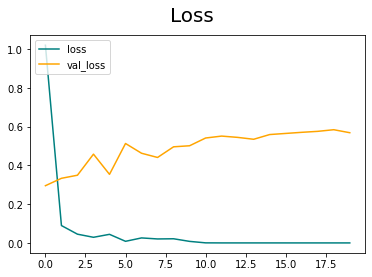

In [23]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

La función de pérdida en el conjunto de entrenamiento comenzó en 1 y disminuyó rápidamente hasta llegar a valores extremadamente bajos, cerca de cero , lo que indica que el modelo se ajustó muy bien a los datos de entrenamiento. Sin embargo, la pérdida de validación inicialmente disminuyó hasta 0.2, pero luego comenzó a aumentar, alcanzando 0.5 al final del entrenamiento. Este aumento en la pérdida de validación mientras la pérdida de entrenamiento sigue disminuyendo es un signo clásico de Overfitting: el modelo se está ajustando demasiado bien a los datos de entrenamiento y pierde generalidad para predecir datos no vistos.

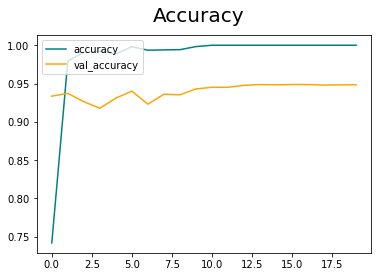

In [24]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

La precisión en el conjunto de entrenamiento aumentó hasta alcanzar un perfecto 100%, mientras que en el conjunto de validación, aumentó hasta un 94%. El hecho de que la precisión en el conjunto de entrenamiento sea perfecta y que la precisión de validación sea significativamente más baja sugiere nuevamente que el modelo podría tener Overfitting.

Accuracy: 0.9438444924406048
Precision: 0.9427069502612704
Recall: 0.9395171188070168


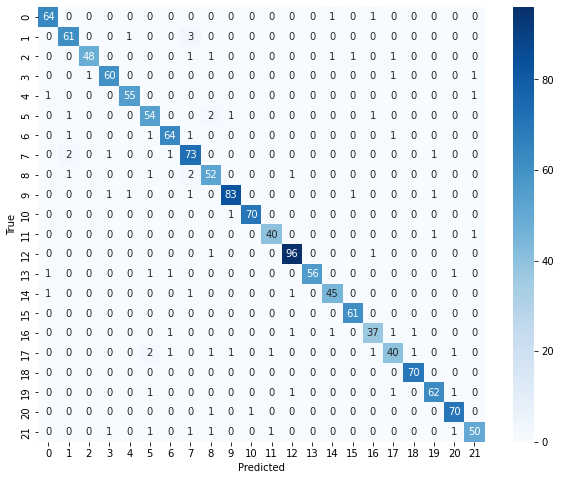

In [25]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


y_true = []
y_pred = []

for batch in test.as_numpy_iterator():
    X, y = batch
    y_true.extend(y)
    preds = model.predict(X)
    y_pred.extend(np.argmax(preds, axis=1))

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')  
recall = recall_score(y_true, y_pred, average='macro') 

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

finalmente vemos los resultados con una matriz de confusion, como se puede observar el modelo erra muy pocas veces alcanzando un Accuracy del 93%, una precision del 93% y un Recall del 93%, hay que tener en cuenta que el modelo tiene que clasficar entre 22 clases de ejercicios distintos y se necesitan mas pruebas para comprobr que esto realmente esta funcionando bien, ya que  por lo comentado anteriormente seguramente estemos ante la presencia de overfitting


### filtros convolutivos

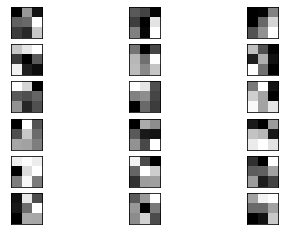

In [26]:

filters, biases = model.layers[0].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min) 


n_filters, ix = 6, 1
for i in range(n_filters):
    f = filters[:, :, :, i]
    for j in range(3):  
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
plt.show()

Ahora creo una funcion para generar distintos modelos para ir probando distintos hiperparametros, en esta parte a su vez vamos a agregar Data augmentation, lo hacemos agregando 4 capas a nuestro modelo:

- <b>Rescaling: </b> Esta capa reescala los valores de los píxeles de las imágenes.


- <b>RandomFlip: </b> Esta capa aplica un volteo horizontal aleatorio a las imágenes.


- <b>RandomRotation: </b> Esta capa rota las imágenes un número aleatorio de grados dentro de un rango especificado, en nuestro de caso de -36 a +36 grados.


- <b>RandomZoom: </b> Esta capa aplica un zoom aleatorio a las imágenes.


In [27]:
from tensorflow.keras import layers, models

def build_model(hp):
    model = models.Sequential()
    
    # Data augmentation
    model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)))
    model.add(tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"))
    model.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.1))
    model.add(tf.keras.layers.experimental.preprocessing.RandomZoom(0.1))

    # Convolutional layers
    for i in range(hp['num_conv_layers']):
        model.add(layers.Conv2D(filters=hp['num_filters'][i], kernel_size=hp['kernel_size'][i], activation=hp['activation'], padding='same'))
        model.add(layers.MaxPooling2D())

    model.add(layers.Flatten())

    # Dense layers at the end
    for i in range(hp['num_dense_layers']):
        model.add(layers.Dense(hp['num_dense_neurons'][i], activation=hp['activation']))

    # Output layer
    model.add(layers.Dense(22, activation='softmax'))  

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=hp['learning_rate'])
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

Lista de hiperparametros a probar: (algunos fueron comentados por temas de memoria de mi pc local)

In [28]:
hp_examples = [
    {'num_conv_layers': 2, 'kernel_size': [(3, 3), (3, 3)], 'num_filters': [32, 64], 'activation': 'relu', 'num_dense_layers': 1, 'num_dense_neurons': [128], 'learning_rate': 0.001},
    {'num_conv_layers': 3, 'kernel_size': [(3, 3), (3, 3), (3, 3)], 'num_filters': [32, 64, 128], 'activation': 'relu', 'num_dense_layers': 2, 'num_dense_neurons': [128, 64], 'learning_rate': 0.001},
    {'num_conv_layers': 4, 'kernel_size': [(5, 5), (5, 5), (3, 3), (3, 3)], 'num_filters': [32, 64, 128, 256], 'activation': 'relu', 'num_dense_layers': 2, 'num_dense_neurons': [256, 128], 'learning_rate': 0.0001},
    {'num_conv_layers': 2, 'kernel_size': [(3, 3), (3, 3)], 'num_filters': [64, 128], 'activation': 'sigmoid', 'num_dense_layers': 1, 'num_dense_neurons': [128], 'learning_rate': 0.01}]
    # {'num_conv_layers': 3, 'kernel_size': [(5, 5), (5, 5), (5, 5)], 'num_filters': [64, 128, 256], 'activation': 'relu', 'num_dense_layers': 2, 'num_dense_neurons': [256, 128], 'learning_rate': 0.001}]
#     {'num_conv_layers': 2, 'kernel_size': [(3, 3), (3, 3)], 'num_filters': [128, 256], 'activation': 'relu', 'num_dense_layers': 1, 'num_dense_neurons': [256], 'learning_rate': 0.0001},
#     {'num_conv_layers': 4, 'kernel_size': [(3, 3), (3, 3), (3, 3), (3, 3)], 'num_filters': [32, 64, 128, 256], 'activation': 'sigmoid', 'num_dense_layers': 2, 'num_dense_neurons': [128, 64], 'learning_rate': 0.01},
#     {'num_conv_layers': 3, 'kernel_size': [(5, 5), (5, 5), (5, 5)], 'num_filters': [32, 64, 128], 'activation': 'relu', 'num_dense_layers': 1, 'num_dense_neurons': [128], 'learning_rate': 0.001},
#     {'num_conv_layers': 2, 'kernel_size': [(5, 5), (5, 5)], 'num_filters': [64, 128], 'activation': 'sigmoid', 'num_dense_layers': 2, 'num_dense_neurons': [256, 128], 'learning_rate': 0.0001},
#     {'num_conv_layers': 4, 'kernel_size': [(3, 3), (3, 3), (5, 5), (5, 5)], 'num_filters': [32, 64, 128, 256], 'activation': 'relu', 'num_dense_layers': 2, 'num_dense_neurons': [256, 128], 'learning_rate': 0.001}
# ]

In [29]:
def train_and_evaluate_models(hp_list, train_data, val_data, epochs=10):
    best_accuracy = 0
    best_model = None
    best_hp = None
    best_history = None

    for hp in hp_list:
        # Build and compile the model
        model = build_model(hp)
        print(f"Training model with hyperparameters: {hp}")
        
        # Train the model
        history = model.fit(train_data, validation_data=val_data, epochs=epochs)
        
        # Evaluate the model
        val_accuracy = max(history.history['val_accuracy'])
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model
            best_hp = hp
            best_history = history
            print(f"New best model with val_accuracy: {val_accuracy}")

    return best_model, best_hp, best_history

In [30]:
best_model, best_hp, best_history = train_and_evaluate_models(hp_examples, train, val)

Training model with hyperparameters: {'num_conv_layers': 2, 'kernel_size': [(3, 3), (3, 3)], 'num_filters': [32, 64], 'activation': 'relu', 'num_dense_layers': 1, 'num_dense_neurons': [128], 'learning_rate': 0.001}
Epoch 1/10
606/606 [==============================] - 26s 41ms/step - loss: 3.0816 - accuracy: 0.0706 - val_loss: 3.0785 - val_accuracy: 0.0683
Epoch 2/10
606/606 [==============================] - 25s 41ms/step - loss: 3.0753 - accuracy: 0.0719 - val_loss: 3.0779 - val_accuracy: 0.0694
Epoch 3/10
606/606 [==============================] - 26s 42ms/step - loss: 3.0752 - accuracy: 0.0719 - val_loss: 3.0764 - val_accuracy: 0.0715
Epoch 4/10
606/606 [==============================] - 25s 42ms/step - loss: 3.0751 - accuracy: 0.0721 - val_loss: 3.0765 - val_accuracy: 0.0719
Epoch 5/10
606/606 [==============================] - 26s 42ms/step - loss: 3.0747 - accuracy: 0.0722 - val_loss: 3.0780 - val_accuracy: 0.0712
Epoch 6/10
606/606 [==============================] - 26s 42ms/st

### Arquitectura del mejor modelo 

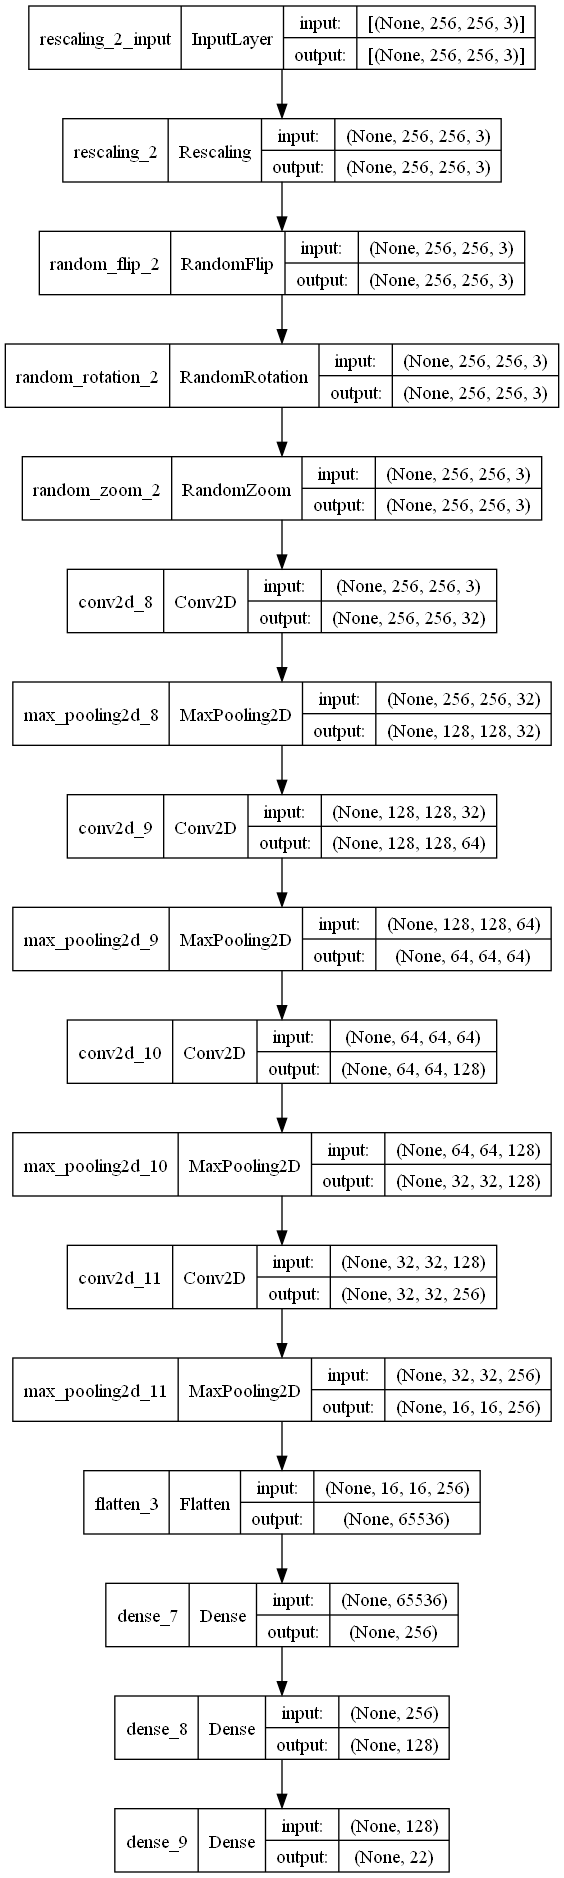

In [45]:
from tensorflow.keras.utils import plot_model


directory = 'model architecture'
if not os.path.exists(directory):
    os.makedirs(directory)

plot_model(best_model, to_file=f'{directory}/BestModel.png', show_shapes=True)

In [39]:
def plot_learning_curves(history):
    # Extracting the data from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plotting the Loss curves
    fig = plt.figure()
    plt.plot(epochs, loss, color='teal', label='Training Loss')
    plt.plot(epochs, val_loss, color='orange', label='Validation Loss')
    fig.suptitle('Loss', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

    # Plotting the Accuracy curves
    fig = plt.figure()
    plt.plot(epochs, acc, color='teal', label='Training Accuracy')
    plt.plot(epochs, val_acc, color='orange', label='Validation Accuracy')
    fig.suptitle('Accuracy', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

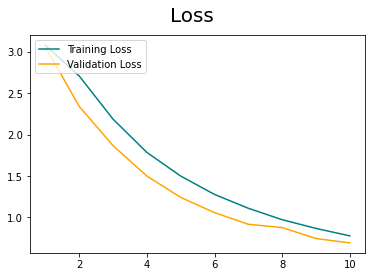

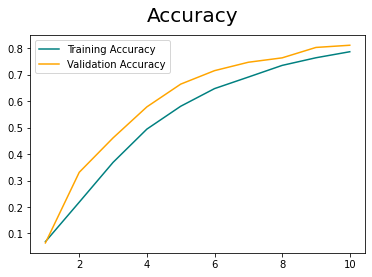

In [43]:

plot_learning_curves(best_history)

Con las curvas de aprendisaje podemos ver una mejora constante y convergente en la precisión y una disminución en la pérdida. Esto es indicativo de un modelo que está aprendiendo bien, sin signos evidentes de overfitting

Accuracy: 0.8293736501079914
Precision: 0.8300875462798235
Recall: 0.826231452840916


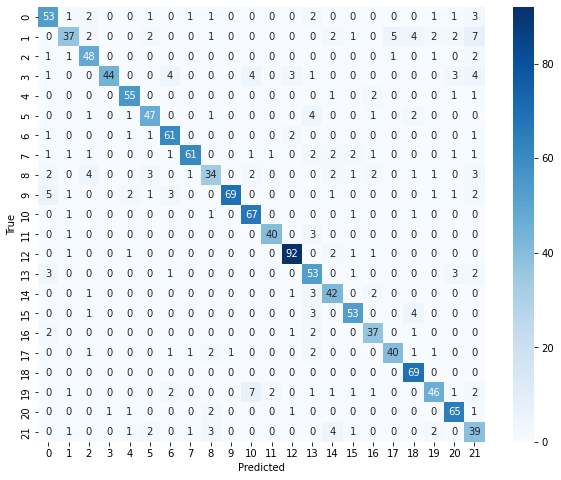

In [38]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


y_true = []
y_pred = []

for batch in test.as_numpy_iterator():
    X, y = batch
    y_true.extend(y)
    preds = best_model.predict(X)
    y_pred.extend(np.argmax(preds, axis=1))

# Calcula las métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')  
recall = recall_score(y_true, y_pred, average='macro')  

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


 En la matriz de confusion, en general, hay un buen número de predicciones correctas.
 Algunas clases tienen errores sistemáticos más altos que otras, como se puede ver en los valores fuera de la diagonal. Por ejemplo, la segunda fila muestra que el modelo a menudo confunde la segunda clase con la doceaba segunda clase (7 veces)